# THỰC HÀNH 5: XÁC ĐỊNH ĐỐI TUỌNG TRONG ẢNH

## 2.VIẾT CHƯƠNG TRÌNH GÁN NHÃN ẢNH

### 2.1.Gán nhãn ảnh

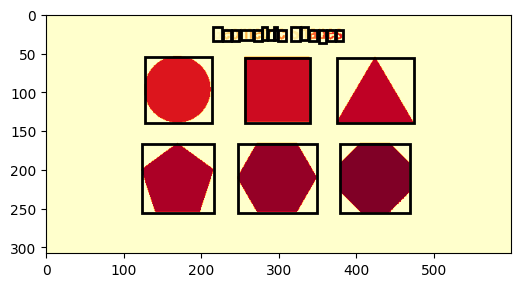

In [6]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Mở ảnh và chuyển sang ảnh mức xám (grayscale)
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)
# Áp dụng phương pháp phân ngưỡng Otsu
thres = threshold_otsu(a)
# Giữ lại các điểm ảnh có cường độ lớn hơn ngưỡng
b = a > thres
# Gán nhãn cho các vùng trong ảnh nhị phân b
c = label(b)
# Chuyển ảnh có nhãn thành định dạng ảnh và lưu lại
c1 = Image.fromarray(c.astype(np.uint8))  # chuyển sang uint8 nếu lỗi
iio.imsave('label_output.jpg', c1)
# Trích xuất thuộc tính từ ảnh đã gán nhãn
properties = ['Area', 'Centroid', 'BoundingBox']
d = regionprops(c)

# Tạo một biểu đồ rỗng với kích thước 6 inch x 6 inch
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')

# Duyệt qua từng đối tượng đã được gán nhãn
for i in d:
    lr, lc, ur, uc = i.bbox
    rec_width = uc - lc   # Chiều rộng hình chữ nhật
    rec_height = ur - lr  # Chiều cao hình chữ nhật
    
    # Vẽ hình chữ nhật bao quanh đối tượng (từ tọa độ (lr, lc))
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height, fill=False,
                              edgecolor='black', linewidth=2)
    
    ax.add_patch(rect)
# Hiển thị biểu đồ
plt.show()


### 2.2.	Dò tìm cạnh theo chiều dọc

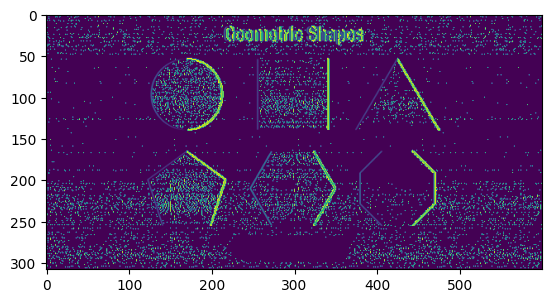

In [7]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu
data = Image.open('geometric.png').convert('L')
bmg = abs(data - nd.shift(data, (0,1), order=0))
plt.imshow(bmg)
plt.show()

### 2.3.Dò tìm cạnh với Sobel Filter

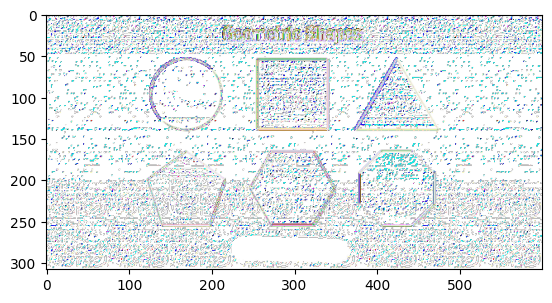

In [8]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

data = Image.open('geometric.png')
a = nd.sobel(data, axis =0)
b = nd.sobel(data, axis = 1)
bmg = abs(a) + abs(b)
plt.imshow(bmg)
plt.show()

### 2.4.Xác định góc của đối tượng

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


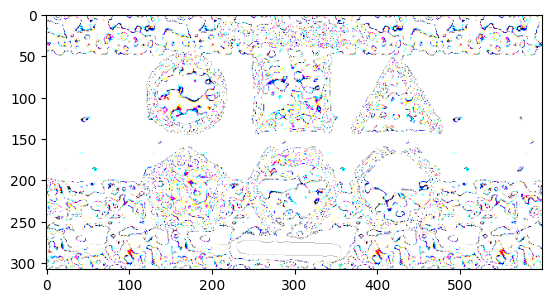

In [ ]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu
def Harris(indata , alpha=0.2):
    # Tính đạo hàm bậc 1 theo x và y bằng Sobel filter
    x = nd.sobel(indata, 0)
    y = nd.sobel(indata, 1)
    # Tính các thành phần của ma trận cấu trúc (structure tensor)
    x1 = x**2
    y1 = y**2
    xy= abs(x*y)
    # Làm mượt các ma trận thành phần bằng bộ lọc Gaussian
    x1 = nd.gaussian_filter(x1, 3)
    y1 = nd.gaussian_filter(y1, 3)
    xy= nd.gaussian_filter(xy,3)
 # Tính định thức và trace của ma trận cấu trúc
    detC = x1 * y1 - 2*xy
    trC = x1 + y1
    R= detC - alpha * trC**2  # công thức điểm góc Harris
    return R

data = Image.open('geometric.png')
bmg = Harris(data)
plt.imshow(bmg)
plt.show()

### 2.5.Dò tìm hình dạng cụ thể trong ảnh với Hough Transform

#### 2.5.1.	Dò tìm đường thẳng trong ảnh

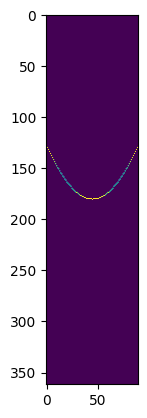

In [ ]:
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Định nghĩa hàm biến đổi Hough để phát hiện đường thẳng
def LineHough(data, gamma):
    # Lấy chiều cao (V) và chiều rộng (H) của ảnh
    V, H = data.shape
    # Tính toán khoảng cách (rho) tối đa, là đường chéo của ảnh
    R = int(np.sqrt(V * V + H * H))
    # Khởi tạo không gian Hough (ma trận tích lũy) với kích thước (R x 90)
    ho = np.zeros((R, 90), float) # Hough space
    # Tạo một bản sao của dữ liệu ảnh đầu vào để xử lý
    w = data + 0
    # Biến cờ để điều khiển vòng lặp
    ok = 1
    # Tạo một mảng gồm 90 góc (theta) từ 0 đến pi/2 (0-90 độ)
    theta = np.arange(90)/180.0 * np.pi
    # Tạo một mảng chỉ số cho các góc theta
    tp = np.arange(90).astype(float)
    
    # Bắt đầu vòng lặp để xử lý các điểm ảnh
    while ok:
        # Tìm giá trị pixel lớn nhất trong ảnh
        mx = w.max()
        # Nếu giá trị lớn nhất nhỏ hơn ngưỡng gamma, dừng vòng lặp
        if mx < gamma:
            ok = 0
        else:
            # Tìm tọa độ (v, h) của pixel có giá trị lớn nhất
            v, h = divmod(w.argmax(), H)
            # Chuyển đổi tọa độ (có thể là để phù hợp với một hệ tọa độ cụ thể)
            y = V - v
            x = h
            # Tính toán các giá trị rho cho điểm (x, y) với tất cả các góc theta
            rh = x * np.cos(theta) + y * np.sin(theta)
            # Duyệt qua từng cặp (rho, theta) đã tính
            for i in range(len(rh)):
                # Kiểm tra xem cặp (rho, theta) có nằm trong giới hạn của không gian Hough không
                if 0 <= rh[i] < R and 0 <= tp[i] < 90:
                    # Tăng giá trị (bỏ phiếu) tại ô tương ứng trong không gian Hough
                    ho[int(rh[i]), int(tp[i])] += mx
            # Xóa pixel đã xử lý bằng cách đặt giá trị của nó về 0
            w[v,h] = 0
    # Trả về không gian Hough đã được tích lũy
    return ho

# Tạo một ảnh đen kích thước 256x256
data = np.zeros((256, 256))
# Đặt một pixel tại tọa độ (128, 128) thành màu trắng (giá trị 1)
data[128, 128] = 1
# Áp dụng biến đổi Hough lên ảnh chỉ có một điểm này
bmg = LineHough(data, 0.5)
# Hiển thị không gian Hough kết quả (sẽ là một đường cong hình sin)
plt.imshow(bmg)
# Hiển thị cửa sổ đồ thị
plt.show()

#### 2.5.2.	Dò tìm đường tròn trong ảnh

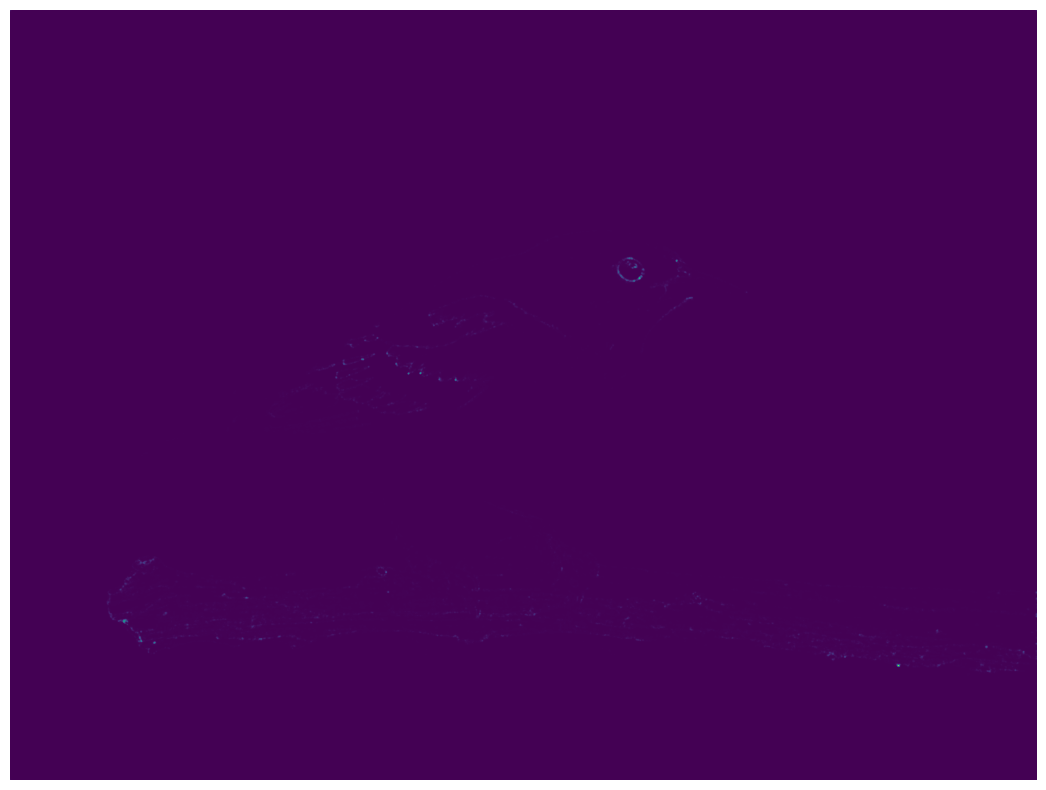

In [ ]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

# Đọc file ảnh 'bird.png' và lưu vào biến data
data = iio.imread('bird.png')
# Chuyển ảnh màu (data) sang ảnh thang độ xám
image_gray = rgb2gray(data)
# Áp dụng thuật toán Harris để phát hiện góc trên ảnh xám, k là tham số độ nhạy
coordinate = corner_harris(image_gray, k = 0.001)

# Tạo một cửa sổ hiển thị với kích thước 20x10 inches
plt.figure(figsize=(20,10))
# Hiển thị ảnh kết quả (bản đồ phản hồi góc)
plt.imshow(coordinate)
# Ẩn các trục tọa độ (x, y)
plt.axis('off')
# Hiển thị cửa sổ đồ thị
plt.show()

### 2.6.Image matching 
Tìm điểm tương đồng giữa 2 ảnh
-Tìm điểm cần so sánh (Harris Corner Detector)
-Xem xét vùng chọn hình chữ nhật xung quanh những điểm cần so sánh
-Tính mô tả đặc trưng cục bộ cho mỗi điểm của mỗi ảnh
-Kiểm tra độ tương đồng giữa hai ảnh

Harris: 2074 keypoints ở ảnh 1, 14924 keypoints ở ảnh 2
SIFT descriptor: (2074, 128) (14924, 128)
Tổng số matches: 221
Số inliers sau RANSAC: 25


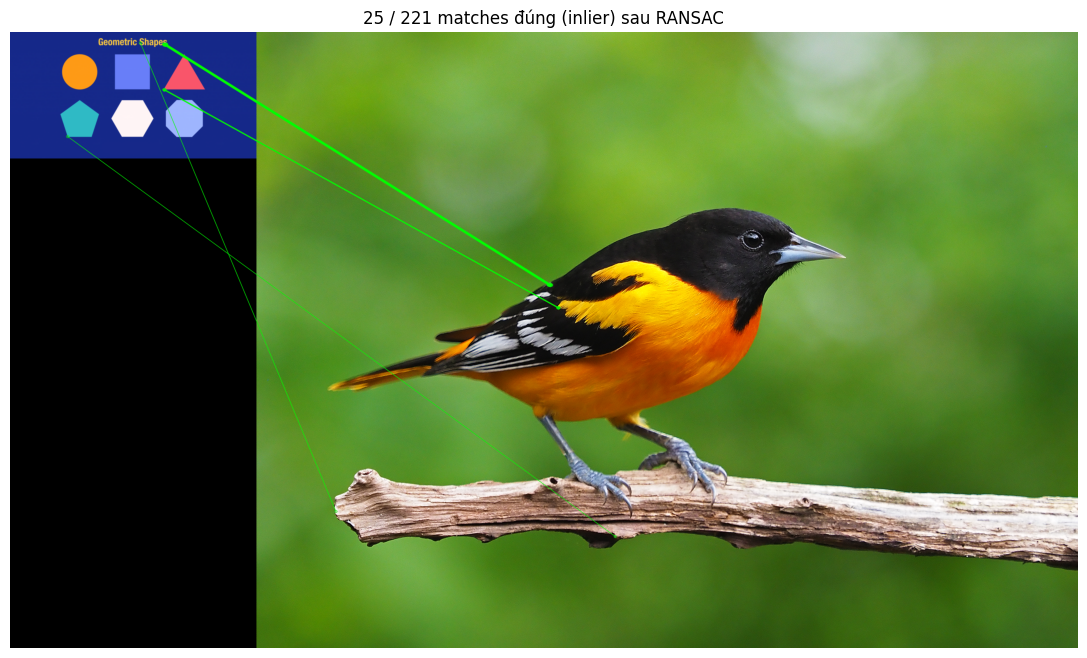

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. ĐỌC ẢNH ----------
img1 = cv2.imread('geometric.png')          
img2 = cv2.imread('bird.png')         
assert img1 is not None and img2 is not None, "Không tìm được file ảnh!"

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ---------- 2. PHÁT HIỆN GÓC BẰNG HARRIS ----------
def harris_keypoints(gray, k=0.04, thresh=0.01):
    harris = cv2.cornerHarris(np.float32(gray), blockSize=2, ksize=3, k=k)
    harris = cv2.dilate(harris, None)
    keypoints = np.argwhere(harris > thresh * harris.max())
    return [cv2.KeyPoint(float(x), float(y), 3) for y, x in keypoints]

kp1 = harris_keypoints(gray1)
kp2 = harris_keypoints(gray2)
print(f'Harris: {len(kp1)} keypoints ở ảnh 1, {len(kp2)} keypoints ở ảnh 2')

# ---------- 3. TÍNH DESCRIPTOR BẰNG SIFT ----------
sift = cv2.SIFT_create()
kp1, des1 = sift.compute(gray1, kp1)
kp2, des2 = sift.compute(gray2, kp2)
print("SIFT descriptor:", des1.shape, des2.shape)

# ---------- 4. GHÉP CẶP ĐẶC TRƯNG VỚI BFMatcher ----------
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)  # L2 norm cho SIFT
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda m: m.distance)

# ---------- 5. LỌC OUTLIER BẰNG RANSAC ----------
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

print(f'Tổng số matches: {len(matches)}')
print(f'Số inliers sau RANSAC: {np.sum(matchesMask)}')

# ---------- 6. VẼ KẾT QUẢ ----------
draw_params = dict(
    matchesMask=matchesMask,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0,255,0),
    singlePointColor=(0,0,255)
)

vis = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"{np.sum(matchesMask)} / {len(matches)} matches đúng (inlier) sau RANSAC")
plt.axis('off')
plt.show()
